# Title

In [1]:
"""markdown
    TITLE   :
    AUTHOR  :
    PROJECT :
""";

__author__ = ''
__version__ = ''

<br><br>

- - - 
- - - 


# Prepare

## Imports

In [4]:
from astroPHD import ipython
ipython.run_imports(base=True, astropy=True, matplotlib=True, galpy=True, verbose_imports=False)
from astropy import constants



# GENERAL
import pandas as pd

# CUSTOM

# PROJECT-SPECIFIC

<br><br>

- - - 
- - - 


# Code

In [5]:
drct = "../scripts/get_globular_clusters/result.txt"
summary_table = pd.read_csv(drct, sep='\t')
summary_table = summary_table.iloc[1:,:]
summary_table.rename(columns={'# Name         ':'Name'}, inplace=True)
summary_table['Name'] = summary_table['Name'].str.strip()
summary_table.set_index('Name', inplace=True)
summary_table.head()

,ra,dec,dist,vlos,vloserr,sigma,rmax,pmra,pmdec,pmra_e,pmdec_e,pmcorr,nstar,rscale,pmdisp
Name,,,,,,,,,,,,,,,
NGC_104_47Tuc,6.02363,-72.081,4.5,-17.2,0.2,12.2,40.0,5.237,-2.524,0.039,0.039,-0.002,23917.2,18.30,0.418
NGC_288,13.1885,-26.582,8.9,-44.8,0.1,3.3,12.0,4.267,-5.636,0.054,0.053,0.018,2555.2,6.05,0.082
NGC_362,15.8094,-70.848,8.6,223.3,0.3,8.8,12.0,6.730,-2.535,0.053,0.052,-0.004,1741.3,7.80,0.149
Whiting_1,30.7375,-3.2527,30.1,-130.4,1.8,0.3,3.0,-0.234,-1.782,0.115,0.094,-0.050,11.1,0.48,0.000
NGC_1261,48.0675,-55.216,16.3,71.4,0.2,5.8,10.0,1.632,-2.038,0.057,0.057,0.009,541.7,4.10,0.093


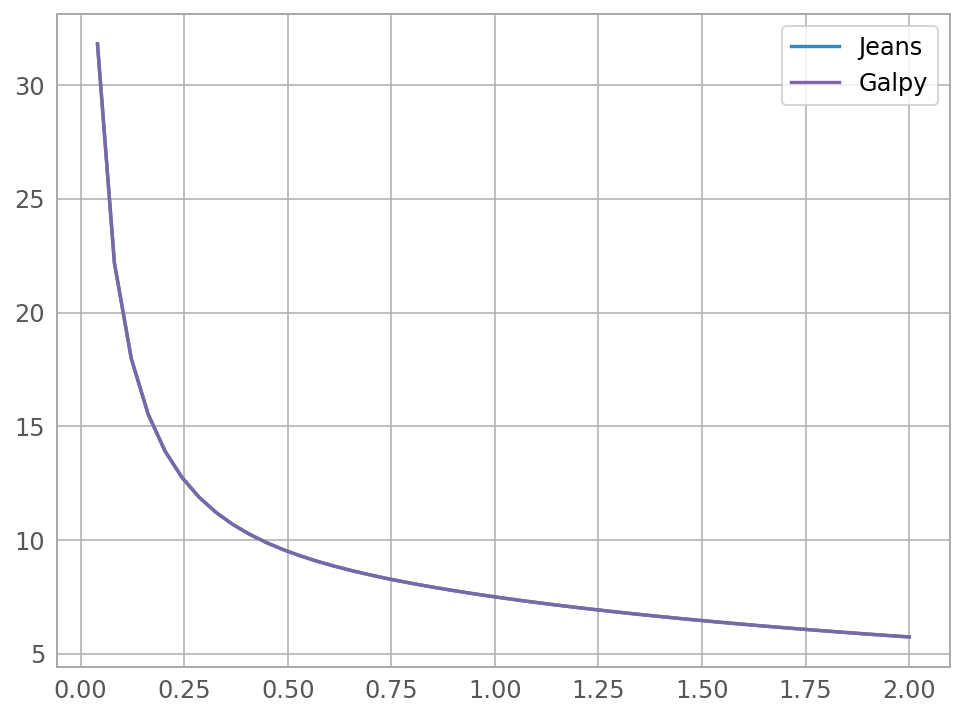

In [36]:
Mgc = 9e5 * u.solMass
mu = (1e5 * u.solMass / Mg).decompose()
x = np.linspace(0, 2, num=50)
a = 10 * u.pc
G = constants.G

sig2 = -(
    G * Mgc
    * (
        -6 * mu
        - 36 * x ** 2 * mu
        - 70 * x ** 4 * mu
        - 56 * x ** 6 * mu
        - 16 * x ** 8 * mu
        + 48 * x ** 3 * np.sqrt(1 + x ** 2) * mu
        + 48 * x ** 5 * np.sqrt(1 + x ** 2) * mu
        + 16 * x ** 7 * np.sqrt(1 + x ** 2) * mu
        + x * np.sqrt(1 + x ** 2) * (-1 + 16 * mu)
    )
) / (6.0 * a * x * (1 + x ** 2))

plt.plot(x, np.sqrt(sig2).to_value(u.km/u.s), label='Jeans')

gc_pot = potential.PlummerPotential(amp=Mgc, b=a)
bh_pot = potential.KeplerPotential(amp=mu * Mgc)

tot_pot = gc_pot + bh_pot

from galpy.df import jeans

def sigmar(r, tot_pot):
    return jeans.sigmar(tot_pot, r).to_value('km/s')

siggalpy = np.array([sigmar(_x * a, tot_pot) for _x in x]) * u.km / u.s

plt.plot(x, siggalpy.to_value(u.km/u.s), label='Galpy')
plt.legend()

## On a Grid

It might be a terrible idea to evaluate jeans modeling during the sampling... I had to kill it anyway. In contrast interpolating model grid seems feasible: I made a try by fitting mock data generated by Galpy w/ a sparse pre-computed mini-grid using grid points only (no interpolation b/w them) and it runs not badly. I think it is fine to interpolate given the profile are all smooth. @Nathaniel Starkman So it would be great to have a denser model grid to test (my laptop runs terribly slow), saved in arrays.

At least we can show the 1st toy model which is close to observation for the mid report. Also I restructured GMM binning (in notebook/GMM.ipynb).

In [116]:
dist = float(summary_table.loc['NGC_104_47Tuc', 'dist']) * u.kpc
scale = float(summary_table.loc['NGC_104_47Tuc', 'rscale']) * u.arcmin

_scale = dist * np.tan(scale)
_scale.to('pc')

<Quantity 23.95487025 pc>

In [120]:
# Grid Parameters for 47 Tuc

gc_amp = np.linspace(9e5, 1.1e6, num=5e1) * u.solMass  # The GC mass varies pretty wildly: 10^4 - few*10^6
gc_scale = np.linspace(0.5, 1.5, num=1e2)
bh_amp = np.linspace(0, 1e5, num=1e2) * u.solMass

# radius
radii = np.linspace(0.01, 4, num=1e2)  # units of radius / scale_radius
Z, phi = 0 * u.kpc, 0 * u.deg

In [121]:
(
 gc_amp_m,    # [:, i, :, :] constant GC amplitude
 gc_scale_m,  # [i, :, :, :] constant GC scale
 bh_amp_m,    # [:, :, i, :] constant BH amp
 radii_m      # [:, :, :, i] constant radius
) = np.meshgrid(gc_amp, gc_scale, bh_amp, radii)

In [122]:
radii_m.shape

(100, 50, 100, 100)

In [123]:
gc_pot = potential.PlummerPotential(amp=gc_amp_m, b=gc_scale_m * _scale)
bh_pot = potential.KeplerPotential(amp=bh_amp_m)

tot_pot = gc_pot + bh_pot

In [124]:
gc_pot_val = gc_pot(radii_m * _scale, Z, phi=0)

In [125]:
bh_pot_val = bh_pot(radii_m * _scale, Z, phi=0)

In [126]:
np.savez_compressed('gc-bh_pot_eval.npz',
                    gc_pot_val=gc_pot_val.to_value(u.km**2/u.s**2),
                    bh_pot_val=bh_pot_val.to_value(u.km**2/u.s**2))

In [127]:
from galpy.df import jeans

@np.vectorize
def sigmar(r, gcamp, gcscale, bhamp):
    gc_pot = potential.PlummerPotential(amp=gcamp * gc_amp.unit, b=gcscale * _scale)
    bh_pot = potential.KeplerPotential(amp=bhamp * bh_amp.unit)

    tot_pot = gc_pot + bh_pot
    
    return jeans.sigmar(tot_pot, r * _scale).to_value('km/s')

In [128]:
sigmar(radii, gc_amp[0].value, gc_scale[-1], bh_amp[-1].value)

array([42.21203188, 18.57060938, 13.69309635, 11.30411984,  9.83289659,
        8.82031202,  8.07579764,  7.50377099,  7.05013925,  6.68160579,
        6.37637058,  6.11947491,  5.9002717 ,  5.710959  ,  5.54568376,
        5.39996972,  5.2703386 ,  5.15405118,  5.0489257 ,  4.95320737,
        4.86547285,  4.78455898,  4.70950892,  4.6395308 ,  4.5739657 ,
        4.51226255,  4.45395829,  4.39866204,  4.34604244,  4.29581743,
        4.2477459 ,  4.20162094,  4.15726426,  4.11452166,  4.0732592 ,
        4.03336009,  3.99472208,  3.9572553 ,  3.92088043,  3.88552717,
        3.85113294,  3.81764187,  3.78500379,  3.75317352,  3.7221102 ,
        3.69177672,  3.66213924,  3.63316681,  3.60483099,  3.57710556,
        3.54996629,  3.52339067,  3.49735776,  3.471848  ,  3.44684308,
        3.4223258 ,  3.39827997,  3.37469034,  3.35154245,  3.32882263,
        3.30651789,  3.28461588,  3.26310482,  3.24197349,  3.22121116,
        3.20080758,  3.18075289,  3.16103769,  3.14165291,  3.12

<br><br>

- - - 
- - - 

<span style='font-size:40px;font-weight:650'>
    END
</span>